In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

# prefix = 'FTTBUSD'
# tick = '1s'

# path = 'input/'
# extension = 'csv'
# os.chdir(path)
# result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
# os.chdir('..')

# # input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
# print(result)
# # input_filename = 'input/test.csv'
# output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

# price_data = processing.import_binance_prices(path, result)[::1200]
# # price_data2 = processing.de_freq(price_data, 180)
# # price_list = [None]*len(price_data)
# final_price = price_data[-1]
# price_data.extend([final_price] * 100)
# price_list = [{'DOT':data.price} for data in price_data]
# print(price_list[0:10])

prefix = 'BTCBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)[::1200]
# price_data2 = processing.de_freq(price_data, 180)
# price_list = [None]*len(price_data)
final_price = price_data[-1]
price_data.extend([final_price] * 100)
price_list = [{'DOT':data.price} for data in price_data]
print(price_list[0:10])

['BTCBUSD-1s-2022-11-20.csv', 'BTCBUSD-1s-2022-11-21.csv', 'BTCBUSD-1s-2022-11-22.csv']
[{'DOT': 16682.5}, {'DOT': 16681.6}, {'DOT': 16713.34}, {'DOT': 16703.46}, {'DOT': 16677.82}, {'DOT': 16696.17}, {'DOT': 16665.47}, {'DOT': 16682.36}, {'DOT': 16688.71}, {'DOT': 16665.61}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 2500, 'weight': 0.40},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=dynamic_fee(
                minimum=0.0025, 
                decay=0, 
                amplification=20, 
                raise_oracle_name='fee_raise'
            ),
            oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
            asset_fee=dynamic_fee(
                minimum=0.0025, 
                decay=0, 
                amplification=20, 
                raise_oracle_name='fee_raise'
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)
print(f'Running with {len(price_list)} time steps')
time_steps = len(price_list)-1
events = run.run(initial_state, time_steps=time_steps)
events = processing.postprocessing(events, optional_params=['withdraw_val'])

316
Starting simulation...
Execution time: 0.592 seconds.
{'state': global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee: Dynamic fee (oracle=fee_raise, decay=0, amplification=20, min=0.0025)
    asset fee: Dynamic fee (oracle=fee_raise, decay=0, amplification=20, min=0.0025)
    asset pools: (
    
        *HDX*
        asset quantity: 21930750.24127661
        lrna quantity: 15784269.69819061
        USD price: 0.719732317615
        tvl: $1096537.5120638306
        weight: 15784269.69819061/157383830.81876874 (0.10029155864408064)
        weight cap: 1.0
        total shares: 22000010.789953476414086042337637605381912341361881
        protocol shares: 20000000.0
    
        *USD*
        asset quantity: 2193075.0241276613
        lrna quantity: 31568539.39638122
        USD price: 14.394646352301
        tvl: $2193075.0241276613
        weight: 31568539.39638122/157383830.81876874 (0.20058311728816128)
        weight cap: 

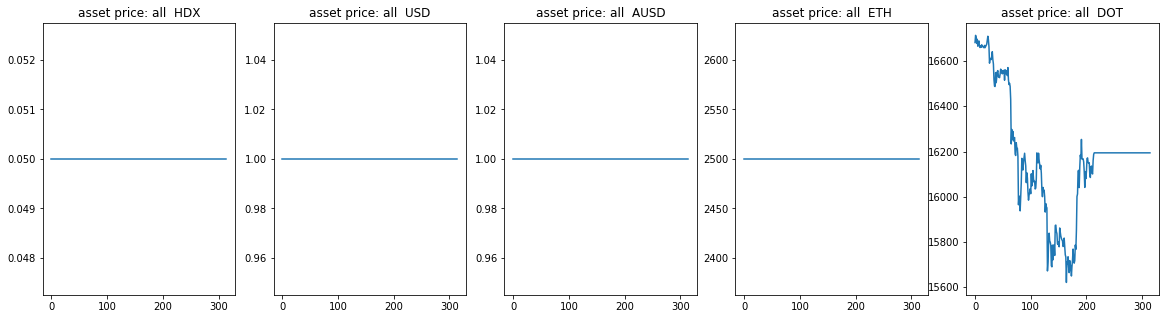

In [3]:
pu.plot(events, asset='all')

:::FEES:::


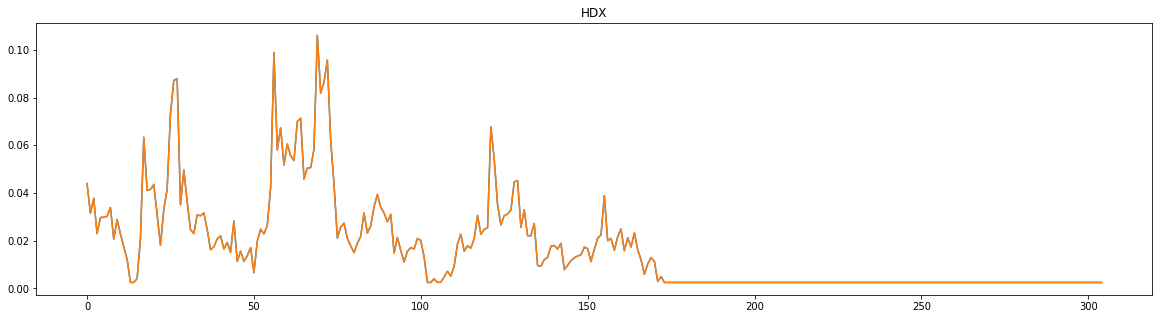

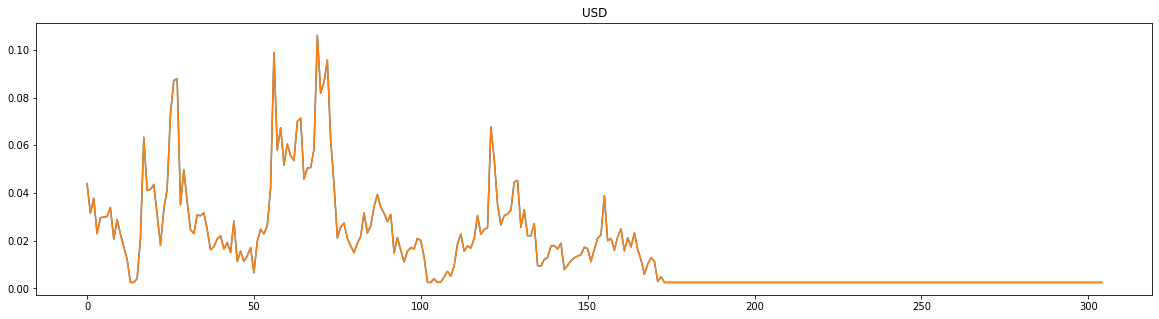

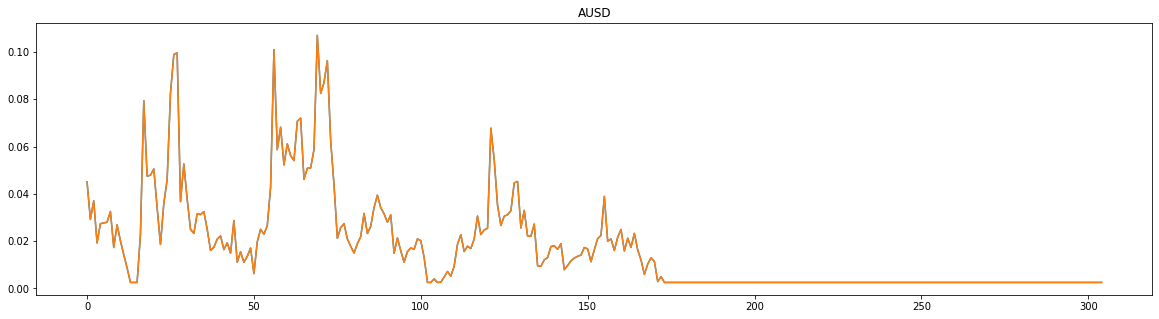

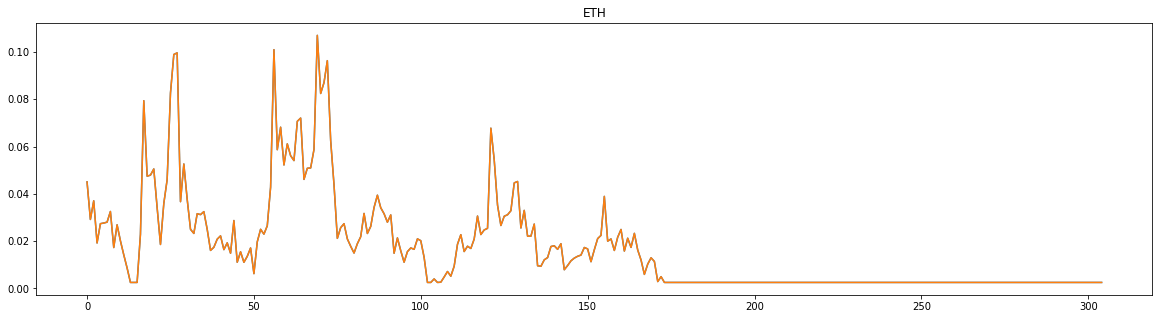

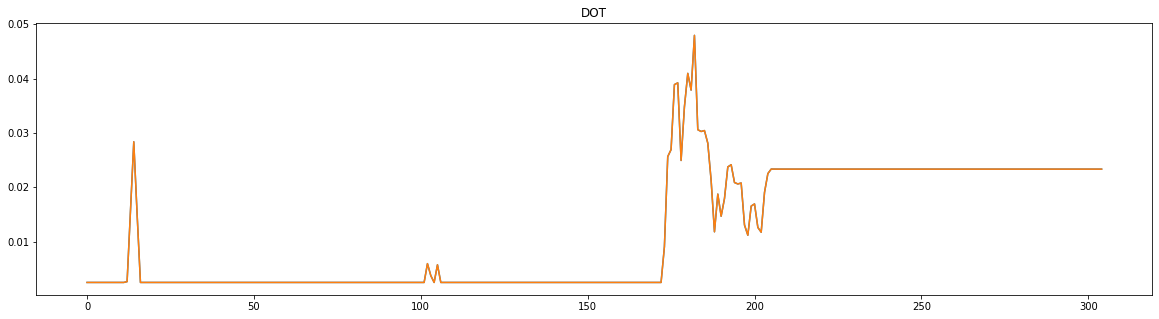

In [10]:
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    asset_fee = [event['state'].pools['omnipool'].asset_fee.compute(tkn, 1) for event in events[10:]]
    lrna_fee = [event['state'].pools['omnipool'].lrna_fee.compute(tkn, 1) for event in events[10:]]
    plt.figure(figsize=(20, 5))
    plt.plot(range(len(asset_fee)), asset_fee)
    plt.plot(range(len(lrna_fee)), lrna_fee)
    plt.title(tkn)

In [14]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0025
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 1.061 seconds.


Text(0.5, 1.0, 'LP with dynamic fees (blue) vs 0.25% flat (orange)')

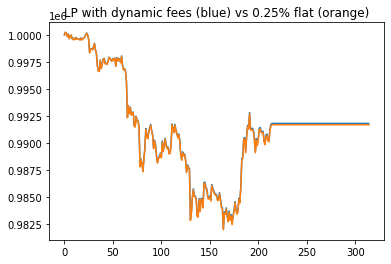

In [21]:
lp_with_fees = [processing.cash_out(event['state'], event['state'].agents['LP']) for event in events]
lp_no_fees = [processing.cash_out(event['state'], event['state'].agents['LP']) for event in events2]
plt.plot(range(len(events)), lp_with_fees)
plt.plot(range(len(events)), lp_no_fees)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')